### COSC102 Assignment 3 - Prepare Data
The purpose of this notebook is to prepare the data for the model training.
We will use the data from the IMU sensor to train a model to predict the activity of the user.



In [1]:
import csv
import matplotlib.pyplot as plt
import math
import numpy as np
import statistics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import plot_confusion_matrix
import dtreeviz

# Set some lists to store the IMU data.

time_track = []
ax_set = []
ay_set = []
az_set = []

gx_set = []
gy_set = []
gz_set = []

activity_set = []


def map_activity(activity_string):
    if activity_string == 'Standing':
        return 0
    elif activity_string == 'Walking':
        return 1
    elif activity_string == 'Jogging':
        return 2
    elif activity_string == 'Side-Step':
        return 3
    elif activity_string == 'Running':
        return 4

In [2]:
# Read the IMU data from the csv file.
with open ('./datasets/a3_imu_data.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        time_track.append(float(row[0]))
        ax_set.append(float(row[1]))
        ay_set.append(float(row[2]))
        az_set.append(float(row[3]))
        gx_set.append(float(row[4]))
        gy_set.append(float(row[5]))
        gz_set.append(float(row[6]))

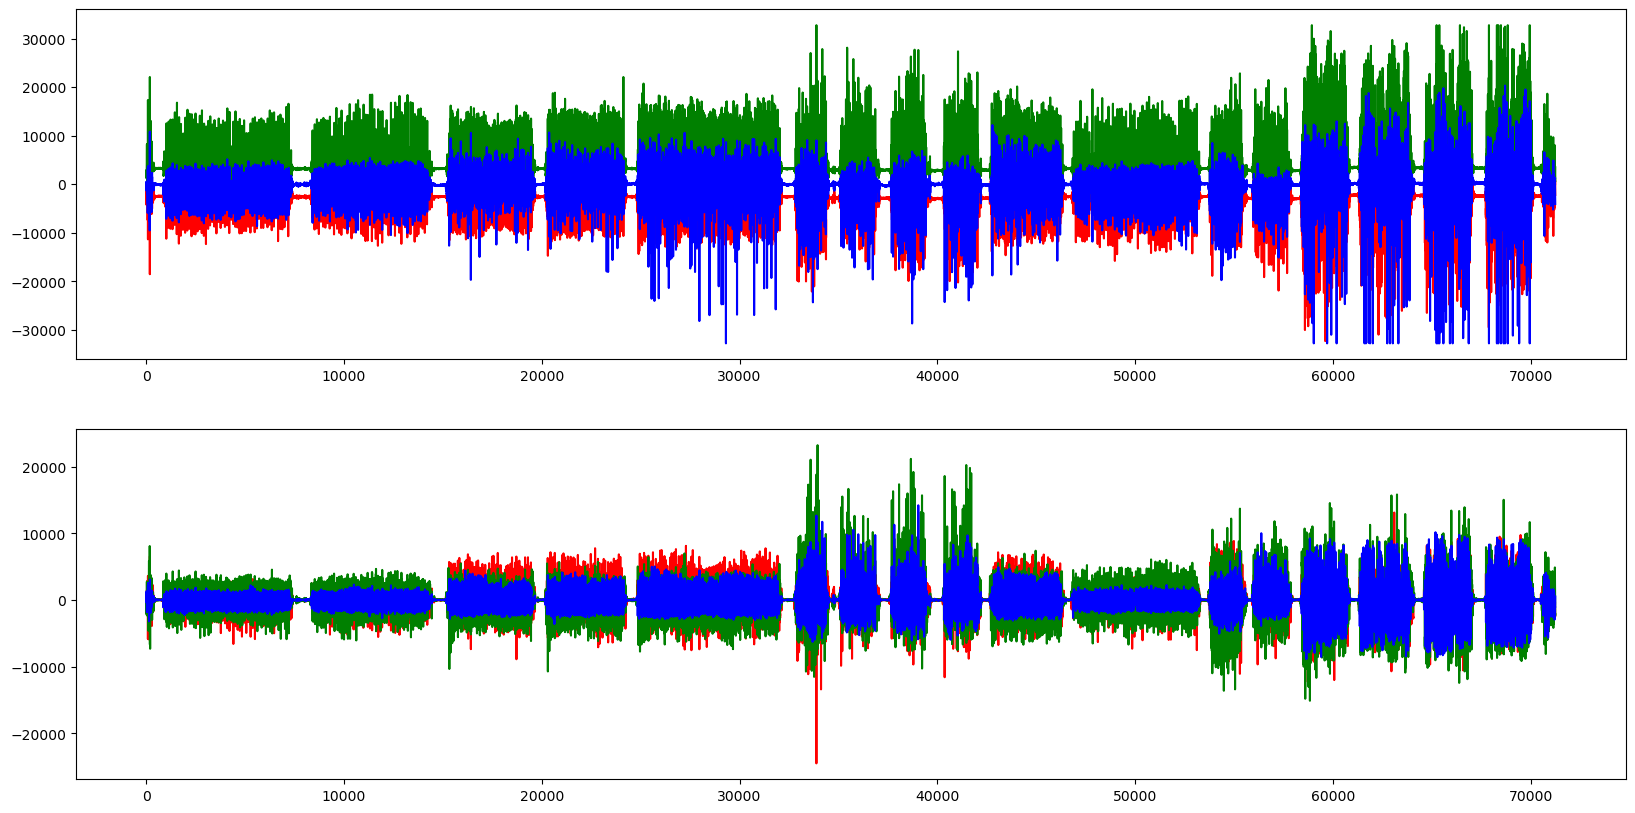

In [3]:
# Check the raw IMU data from the csv file.
fig, axs = plt.subplots(2,1,figsize=(20,10))
axs[0].plot(ax_set, color='r')
axs[0].plot(ay_set, color='g')
axs[0].plot(az_set, color='b')

axs[1].plot(gx_set, color='r')
axs[1].plot(gy_set, color='g')
axs[1].plot(gz_set, color='b')

start_ts:  1598240221.0


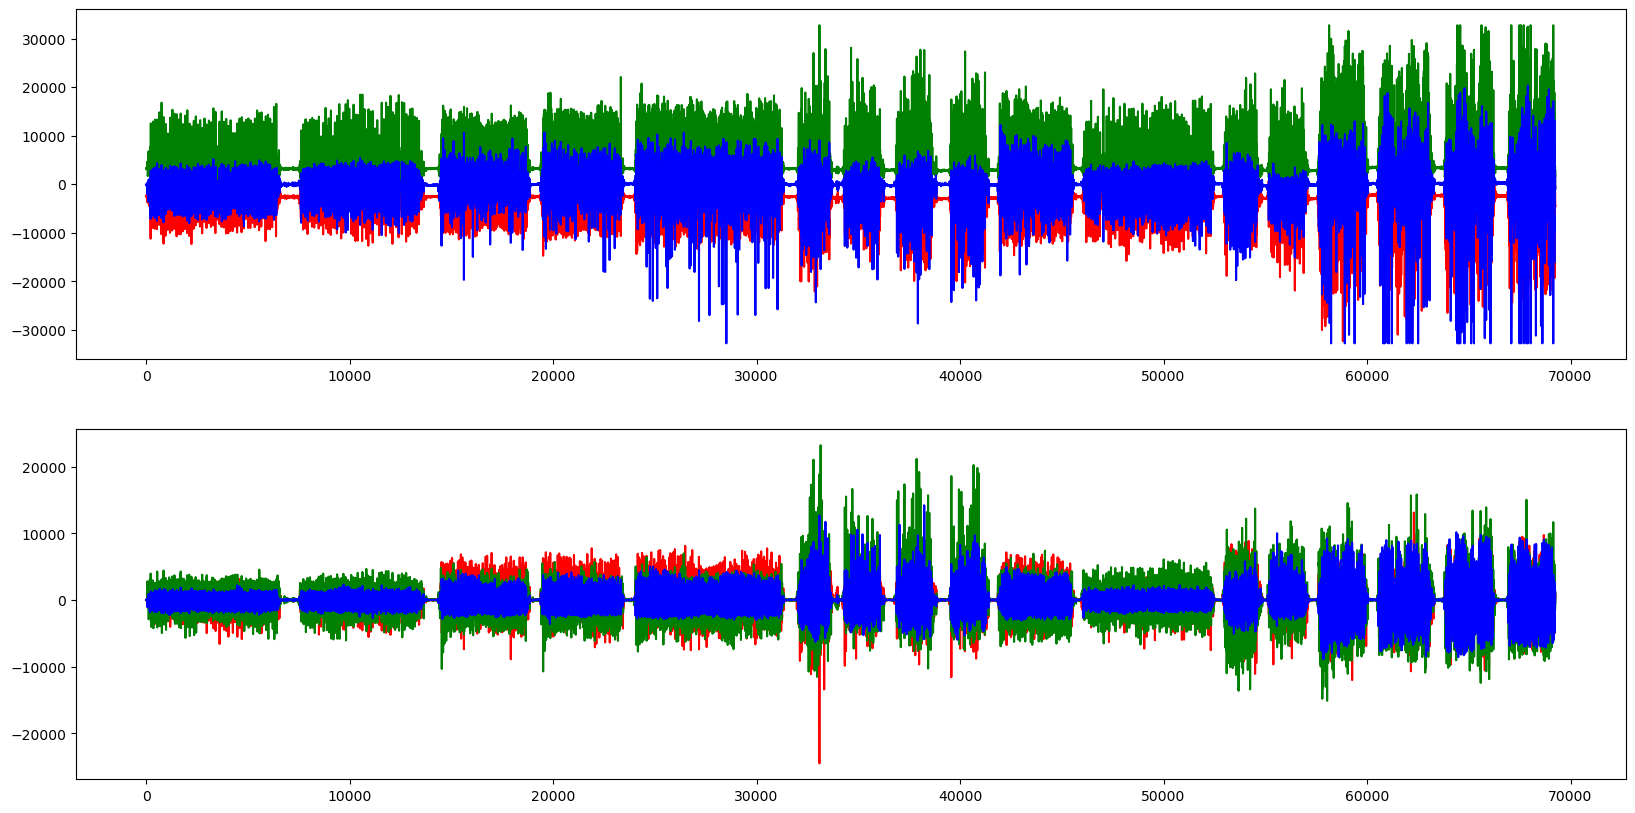

In [4]:
start_idx = 800

start_ts = time_track[start_idx]
print('start_ts: ', start_ts)

end_idx = time_track.index(start_ts + 711)

# Sanity Check
fig, axs = plt.subplots(2,1,figsize=(20,10))
axs[0].plot(ax_set[start_idx:end_idx], color='r')
axs[0].plot(ay_set[start_idx:end_idx], color='g')
axs[0].plot(az_set[start_idx:end_idx], color='b')

axs[1].plot(gx_set[start_idx:end_idx], color='r')
axs[1].plot(gy_set[start_idx:end_idx], color='g')
axs[1].plot(gz_set[start_idx:end_idx], color='b')

In [5]:
# Add activity annotation to the IMU data from the csv file.
with open ('./datasets/a3_activity_annotations.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None) # skip the headers
    for row in reader:
        time_stamp = (row[0].split('='))[1]
        activity_set.append([float(time_stamp),row[-1], map_activity(row[-1])])

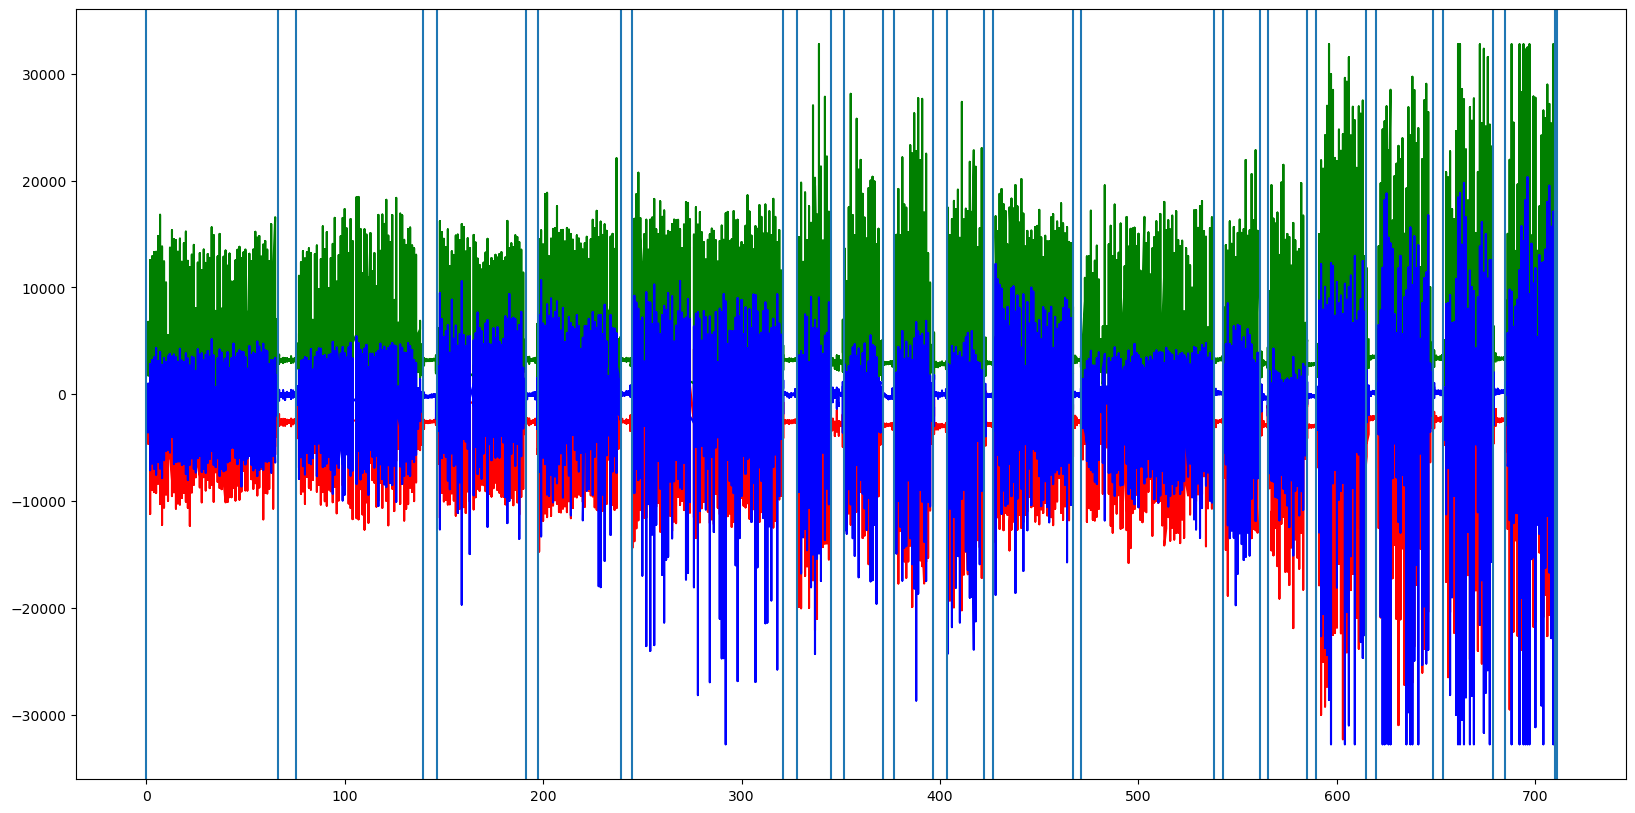

In [6]:
# Now we can create an activity time track for each data point within
# the imu timeseries. We will have a list to store the numeric code and the string.
activity_timeseries = []
activity_string_timeseries = []
activity_idx = 0

# We need the time stamp for the start point
start_time = time_track[start_idx]

# The time track segment we are interested in 
time_track_segment = time_track[start_idx:end_idx]

# #Add an 'end' activity - this book-ends the data
activity_set.append([time_track_segment[-1]-start_time, 'Standing'])

# Zero out the time track segment to make it match the video time
time_track_segment = np.array(time_track_segment)-start_time

ig, ax = plt.subplots(figsize=(20,10))
ax.plot(time_track_segment,ax_set[start_idx:end_idx], color='r')
ax.plot(time_track_segment,ay_set[start_idx:end_idx], color='g')
ax.plot(time_track_segment,az_set[start_idx:end_idx], color='b')


for imu_time_track_item in time_track_segment:
    current_time =  imu_time_track_item
    next_activity_ts = activity_set[activity_idx+1][0]
    
    # Here we need to move to the next activity in the annotations data if the current
    # IMU data point lies after the next annotation time stamp.
    if current_time > next_activity_ts:
        #Move to nex activity
        activity_idx = activity_idx + 1
        next_activity_ts = activity_set[activity_idx+1][0]
    
    
    activity_timeseries.append(activity_set[activity_idx][2])
    activity_string_timeseries.append(activity_set[activity_idx][1])

# Plot the location of the activity transitions just to sanity check the data
for act in np.array(list(zip(*activity_set)))[0,:]:
    ax.axvline(float(act))

(array([ 8892., 19341., 19496., 11303., 10218.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]),
 <BarContainer object of 5 artists>)

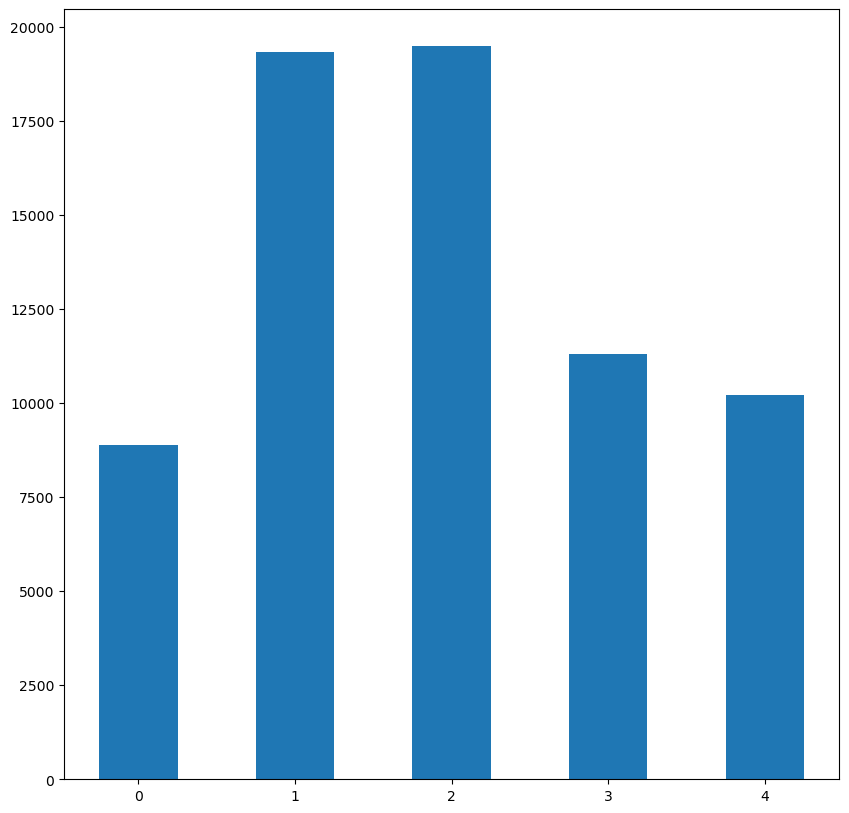

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(activity_timeseries, bins=[-0.5,0.5,1.5,2.5,3.5, 4.5] , rwidth=0.5, align='mid')

In [8]:
#We are only interested in the video window
ax_set = ax_set[start_idx:end_idx]
ay_set = ay_set[start_idx:end_idx]
az_set = az_set[start_idx:end_idx]
gx_set = gx_set[start_idx:end_idx]
gy_set = gy_set[start_idx:end_idx]
gz_set = gz_set[start_idx:end_idx]

In [9]:
# Now we can start working on the machine learning workflow.
# The first step is to calculate some feature that we can use.
# We will base our analysis around a moving window across the
# the timeseries data. This involves taking a fixed length window, based upon the time, and
# sliding it across the data.
# To keep thing simple, we will start with a 1 second window with no overlapping
# data points

feature_set = []
target_set  = []            
window_size = 1.0
bad_data_point = [104, 105, 163, 164, 274, 275]            

for t in range(int(time_track_segment[0]),int(time_track_segment[-1])):
    
    #There is a missing data-point (probably due to a bad segment on the SD card)
    
    if t in bad_data_point:
      continue
    
    #The index function finds the index of the first occurance of the data
    window_start_idx = list(time_track_segment).index(t)
    window_end_idx = list(time_track_segment).index(t+window_size)
    ax_window = ax_set[window_start_idx:window_end_idx]
    ay_window = ay_set[window_start_idx:window_end_idx]
    az_window = az_set[window_start_idx:window_end_idx]
    gx_window = gx_set[window_start_idx:window_end_idx]
    gy_window = gy_set[window_start_idx:window_end_idx]
    gz_window = gz_set[window_start_idx:window_end_idx]

    #activity that will be assigned to the set of features
    activity_code = activity_timeseries[window_start_idx]

    # Now we can build features from the data window
    # Mean
    mu_ax = statistics.mean(ax_window)
    mu_ay = statistics.mean(ay_window)
    mu_az = statistics.mean(az_window)
    mu_gx = statistics.mean(gx_window)
    mu_gy = statistics.mean(gy_window)
    mu_gz = statistics.mean(gz_window)
    
    # Max
    max_ax = max(ax_window)
    max_ay = max(ay_window)
    max_az = max(az_window)
    max_gx = max(gx_window)
    max_gy = max(gy_window)
    max_gz = max(gz_window)
    
    # Min
    min_ax = min(ax_window)
    min_ay = min(ay_window)
    min_az = min(az_window)
    min_gx = min(gx_window)
    min_gy = min(gy_window)
    min_gz = min(gz_window)
    
    ax_abs_sum = 0
    ay_abs_sum = 0
    az_abs_sum = 0
    
    gx_abs_sum = 0
    gy_abs_sum = 0
    gz_abs_sum = 0
    
    a_sum_sq = 0
    g_sum_sq = 0
    
    # Here we need to accumulate the values to calculate the SMA and AI
    for i in range(0, len(ax_window)):
        
        # Add up the absolute values for the SMA
        ax_abs_sum = ax_abs_sum + abs(ax_window[i])
        ay_abs_sum = ay_abs_sum + abs(ay_window[i])
        az_abs_sum = az_abs_sum + abs(az_window[i])
        
        gx_abs_sum = gx_abs_sum + abs(gx_window[i])
        gy_abs_sum = gy_abs_sum + abs(gy_window[i])
        gz_abs_sum = gz_abs_sum + abs(gz_window[i])
        
        
        a_sum_sq = ((ax_window[i]**2) + (ay_window[i]**2) + (az_window[i]**2)) + a_sum_sq
        g_sum_sq = ((gx_window[i]**2) + (gy_window[i]**2) + (gz_window[i]**2)) + g_sum_sq
    
    # Signal Magnitude area    
    a_sma = (ax_abs_sum + ay_abs_sum + az_abs_sum) / len(ax_window)
    g_sma = (gx_abs_sum + gy_abs_sum + gz_abs_sum) / len(ax_window)

    # Average intensity
    a_av_intensity = math.sqrt(a_sum_sq) / len(ax_window)
    g_av_intensity = math.sqrt(g_sum_sq) / len(ax_window)


    feature_row = [mu_ax, mu_ay, mu_az, mu_gx, mu_gy, mu_gz, \
                   max_ax, max_ay, max_az, max_gx, max_gy, max_gz, \
                   min_ax, min_ay, min_az, min_gx, min_gy, min_gz, \
                   a_sma, g_sma, a_av_intensity, g_av_intensity]

    feature_set.append(feature_row)
    target_set.append(activity_code)

    # feature names
feature_names = ['mu_ax', 'mu_ay', 'mu_az', 'mu_gx', 'mu_gy', 'mu_gz', \
                 'max_ax', 'max_ay', 'max_az', 'max_gx', 'max_gy', 'max_gz', \
                 'min_ax', 'min_ay', 'min_az', 'min_gx', 'min_gy', 'min_gz', \
                 'a_sma', 'g_sma', 'a_av_intensity', 'g_av_intensity']



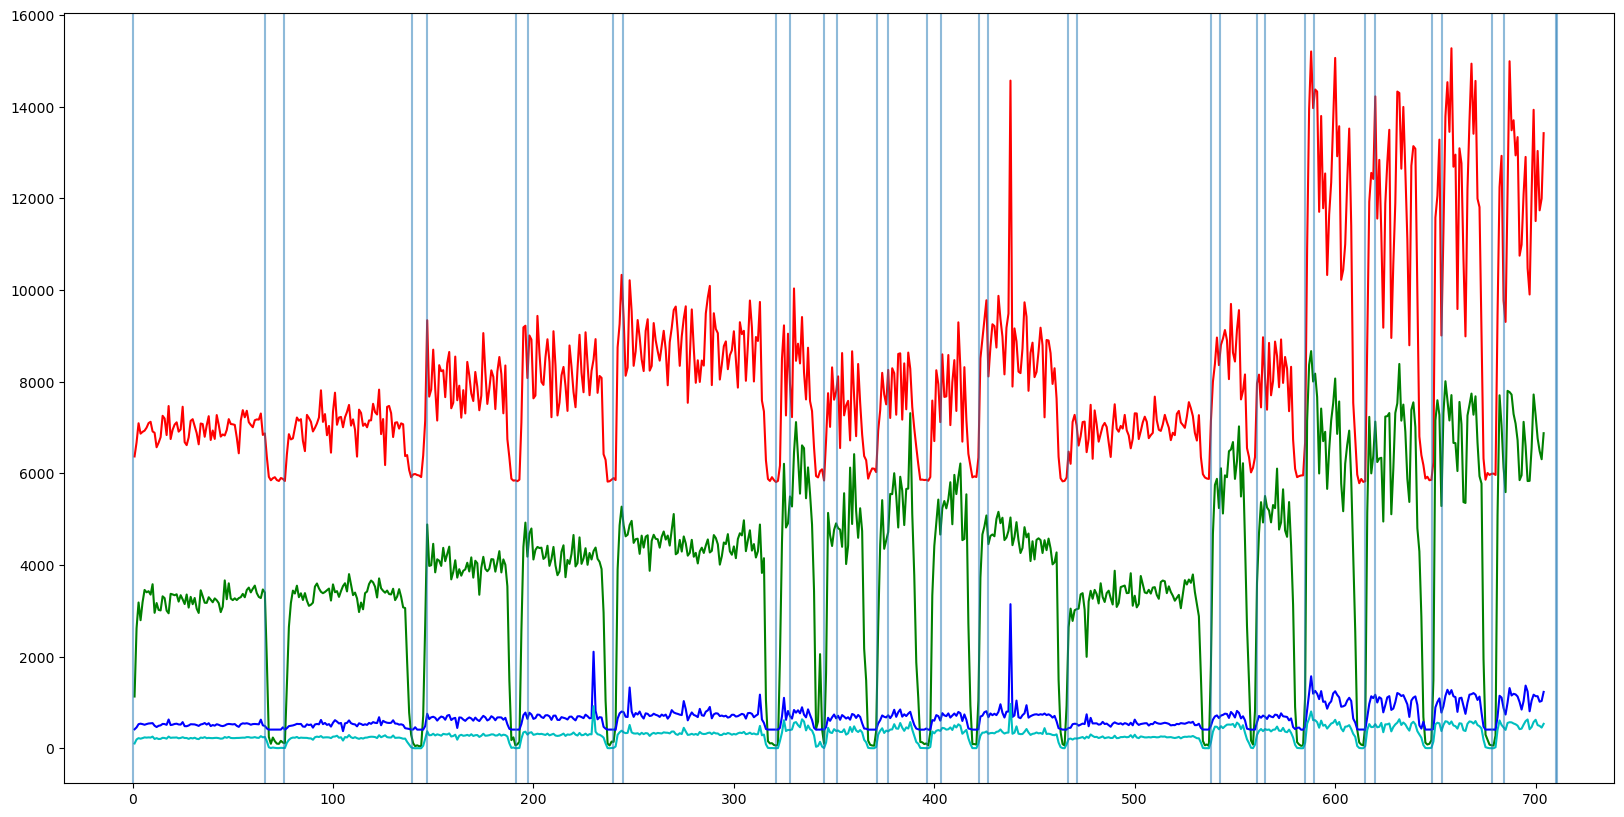

In [10]:
# Lets visualise some of the features just out of interest - we will look at the SMA and AI
plot_range = range(1,705)
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(plot_range,np.array(feature_set)[:,18], color='r')
ax.plot(plot_range,np.array(feature_set)[:,19], color='g')
ax.plot(plot_range,np.array(feature_set)[:,20], color='b')
ax.plot(plot_range,np.array(feature_set)[:,21], color='c')

# Plot the location of the activity transitions just to sanity check the data
for act in np.array(list(zip(*activity_set)))[0,:]:
    ax.axvline(float(act), alpha=0.5)
    

In [11]:
feature_set = np.array(feature_set)
target_set = np.array(target_set)

### Support Vector Machine / Stochastic Gradient Descendent

In [12]:
target_names = list(['Jogging', 'Running', 'Side-Step', 'Standing', 'Walking'])
nclasses = len(target_names)

# train and test datasets
X_train, X_test, y_train, y_test = train_test_split(feature_set, target_set, random_state=42)

# standardise mean and std as the SGD classifier will be used.
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std

In [13]:
# check the alpha range for the SGD classifier 
# keep adjusting to hone in on the best value
alpha_range = np.arange(0.0001, 0.00051, 0.00001)
print(alpha_range)

[0.0001  0.00011 0.00012 0.00013 0.00014 0.00015 0.00016 0.00017 0.00018
 0.00019 0.0002  0.00021 0.00022 0.00023 0.00024 0.00025 0.00026 0.00027
 0.00028 0.00029 0.0003  0.00031 0.00032 0.00033 0.00034 0.00035 0.00036
 0.00037 0.00038 0.00039 0.0004  0.00041 0.00042 0.00043 0.00044 0.00045
 0.00046 0.00047 0.00048 0.00049 0.0005 ]


In [14]:
#initialise highest performing variables
best_performance = 0
best_f1 = 0
best_f2 = 0
best_alpha = 0
f1_set = np.zeros(len(alpha_range))
i = 0

# loop through and store all of the 2 most higher performing features for each alpha
for alpha in alpha_range:


    clf = SGDClassifier(alpha=alpha, random_state=42)
    clf.fit(X_train, y_train)

    # Return the predictions for the 3-Fold crossvalidation
    y_predicted = cross_val_predict(
        clf, X_train, y_train)

    # Store the result
    current_f1 = np.mean(f1_score(y_train, y_predicted, average=None))
    f1_set[i] = current_f1
    
    if current_f1 > best_performance:
        best_performance = current_f1
        best_clf = clf
        best_alpha = alpha
    i = i + 1

In [15]:
# standardise the the mean value of X_test as it must be fit into the best SGD in previous step.
X_test = (X_test - mean) / std
y_test_predicted = best_clf.predict(X_test)
conf_mat_test = confusion_matrix(y_test, y_test_predicted)

# calculate recall, precision and F1 scores for each class
print("Recall Score:", recall_score(y_train,y_predicted,average=None))
print("Precision Score:", precision_score(y_train,y_predicted,average=None))
print("F1 Score:", f1_score(y_train,y_predicted,average=None))
print("Best alpha:", best_alpha)

Recall Score: [0.91176471 0.93571429 0.96621622 0.88235294 0.89655172]
Precision Score: [0.87323944 0.90972222 0.9862069  0.91463415 0.90697674]
F1 Score: [0.89208633 0.92253521 0.97610922 0.89820359 0.9017341 ]
Best alpha: 0.00031999999999999997


Text(0.5, 1.0, 'Best classified F1 Scores')

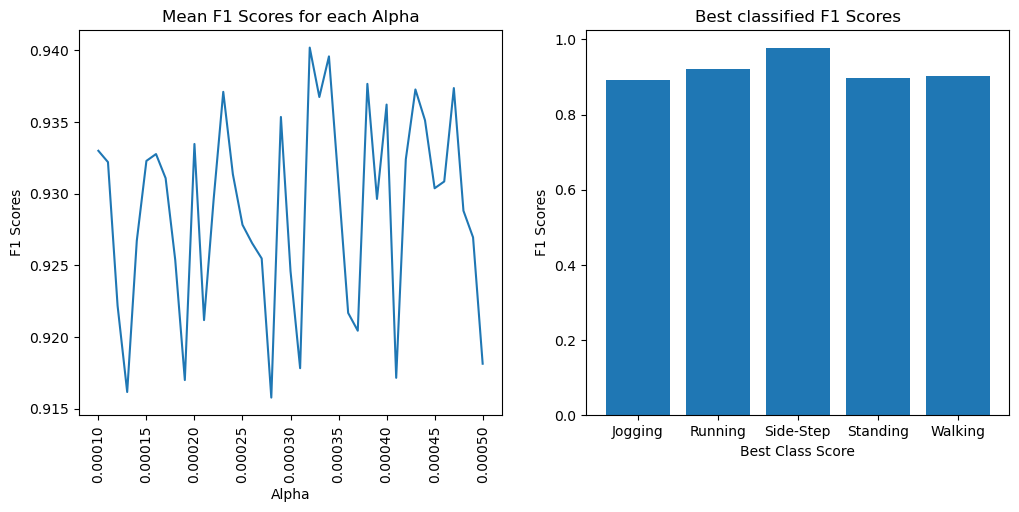

In [16]:
# Plot f1_scores for each iteration
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5))
ax1.plot(alpha_range, f1_set)
ax1.set_xlabel('Alpha')
ax1.set_ylabel('F1 Scores')
ax1.set_title('Mean F1 Scores for each Alpha')

for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
ax1.plot()


ax2.bar(target_names, f1_score(y_train,y_predicted,average=None))
ax2.set_xlabel('Best Class Score')
ax2.set_ylabel('F1 Scores')
ax2.set_title('Best classified F1 Scores')


/home/squid/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
/home/squid/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


Text(0.5, 1.0, 'Test Data Confusion Matrix')

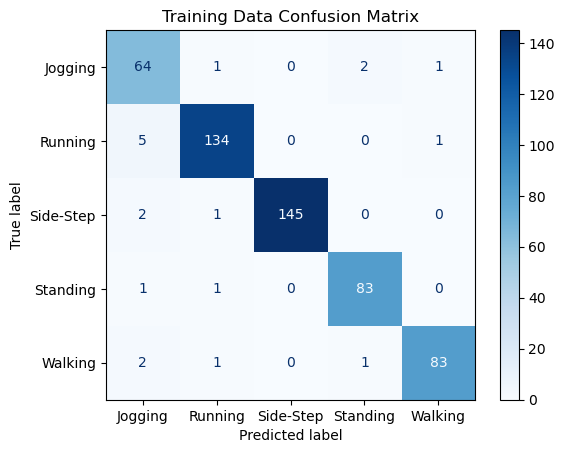

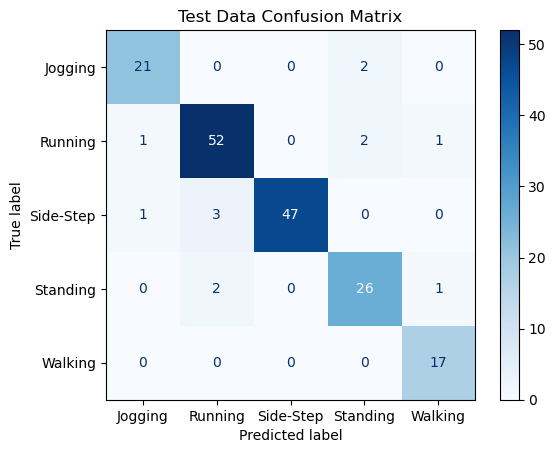

In [17]:
# Plot the confusion matrices
fig, ax = plt.subplots()
plot_confusion_matrix(best_clf, X_train, y_train,
                                 display_labels=target_names,
                                 cmap=plt.cm.Blues,ax=ax)
ax.set_title('Training Data Confusion Matrix')

fig, ax = plt.subplots()
plot_confusion_matrix(best_clf, X_test, y_test,
                                 display_labels=target_names,
                                 cmap=plt.cm.Blues,ax=ax)
ax.set_title('Test Data Confusion Matrix')

In [18]:
y_score = best_clf.decision_function(X_test)

# format the y_test into a n_samples x 5 binary array that indicates class membership
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4]) 

# Plot a ROC curve and calculate the AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(nclasses):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

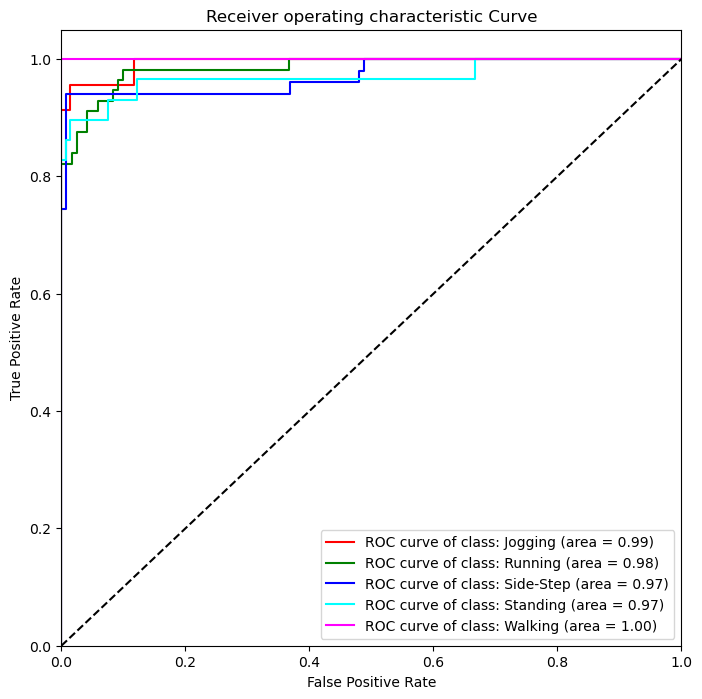

In [19]:
# Plot the TPR vs FPR for each class
fig, ax = plt.subplots(figsize=(8,8))
colors = ['red', 'green', 'blue', 'cyan', 'magenta']
for i, color in zip(range(nclasses), colors):
    ax.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class: {0} (area = {1:0.2f})'
             ''.format(target_names[i], roc_auc[i]))
    
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic Curve')
ax.legend(loc="lower right")

In [20]:
# find the most important features
importances = best_clf.coef_[0]
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))

# save the top 5 most important features
most_important_features = []
for f in range(5):
    most_important_features.append(feature_names[indices[f]])


Feature ranking:
1. feature min_ax (9.211712)
2. feature min_az (5.067361)
3. feature min_gz (4.133703)
4. feature mu_gz (2.920379)
5. feature min_gy (2.605966)
6. feature min_gx (2.047196)
7. feature mu_az (0.875852)
8. feature min_ay (0.807442)
9. feature mu_gy (-0.938543)
10. feature mu_ax (-2.082178)
11. feature max_gz (-3.671988)
12. feature max_ay (-3.864117)
13. feature max_ax (-4.037176)
14. feature mu_ay (-4.145796)
15. feature mu_gx (-4.368726)
16. feature a_sma (-4.804467)
17. feature max_az (-5.227305)
18. feature g_sma (-6.035521)
19. feature max_gy (-6.181484)
20. feature max_gx (-6.942332)
21. feature g_av_intensity (-7.647957)
22. feature a_av_intensity (-8.109815)


In [21]:
# set up the data to use the seaborn pairplot function

import pandas as pd

df = pd.DataFrame(X_test, columns=[feature_names[i-1] for i in range(1, 23)])
df['Target'] = y_test

# set target names
df['Target'] = df['Target'].replace(0, 'Standing')
df['Target'] = df['Target'].replace(1, 'Walking')
df['Target'] = df['Target'].replace(2, 'Jogging')
df['Target'] = df['Target'].replace(3, 'Side-Step')
df['Target'] = df['Target'].replace(4, 'Running')


df.head()

,mu_ax,mu_ay,mu_az,mu_gx,mu_gy,mu_gz,max_ax,max_ay,max_az,max_gx,...,min_ay,min_az,min_gx,min_gy,min_gz,a_sma,g_sma,a_av_intensity,g_av_intensity,Target
0,1.391862,-0.305961,0.818294,-0.853912,0.486736,-0.488706,0.686188,0.147330,0.790660,1.331341,...,0.271190,0.300057,-0.089205,-0.345404,0.227952,0.022565,0.351373,-0.014876,0.213382,Jogging
1,-0.193278,-0.345883,-0.488436,0.787799,-0.293520,-0.279967,-0.678971,-0.220268,-0.492412,-0.722618,...,0.015860,0.553219,0.267949,0.216040,0.671318,-0.486026,-0.229998,-0.571992,-0.338318,Walking
2,-0.330242,-1.042522,-0.546974,-0.535004,-0.749157,0.192746,-0.781160,-0.545279,-0.785855,-0.860926,...,0.679719,0.239082,0.939033,0.588587,0.698359,-0.661288,-0.695513,-0.771796,-0.754179,Walking
3,1.129843,-1.008939,0.111572,0.068724,-0.017979,-0.085957,0.256542,0.117461,0.136471,0.872141,...,0.253847,0.668222,0.141330,-0.310173,0.211625,-0.482890,0.070388,-0.219129,-0.008289,Jogging
4,0.142083,-0.540200,0.472327,-0.064484,0.065693,0.119143,-1.340661,-1.689771,-1.404507,-1.655775,...,1.980459,1.218283,1.780835,1.728716,1.375909,-1.114077,-2.006352,-1.082344,-1.890916,Standing


Text(0.5, 1.05, 'Pairplot of the 5 most important features for SGD Classifier')

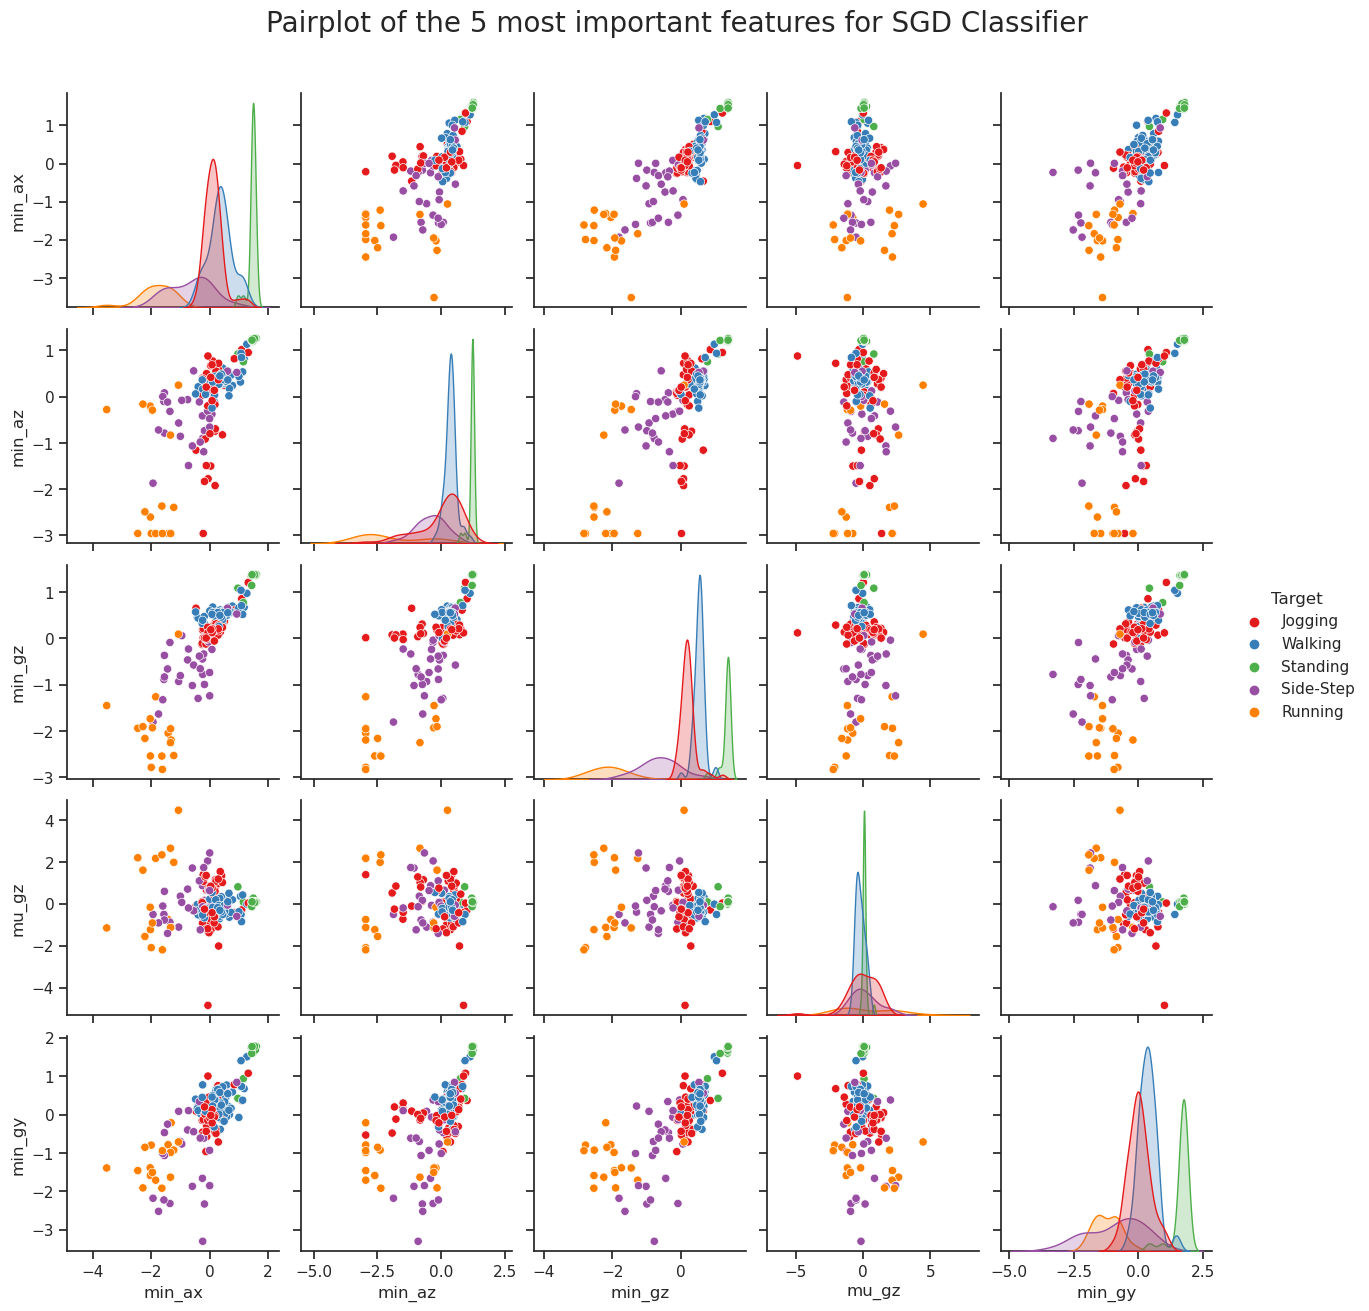

In [25]:
# pairplot the top 5 most important features

import seaborn as sns
sns.set(style="ticks", color_codes=True)

sns.pairplot(df, hue='Target', palette="Set1", diag_kind="kde", height=2.5, vars=most_important_features)
# set the pairplot title
plt.suptitle('Pairplot of the 5 most important features for SGD Classifier', y=1.05, fontsize=20)


